In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
df = pd.read_csv('./Train_V2.csv')

def preprocess(df,x) :
    
    
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    x_country = df.country
    x_id = df.uniqueid
    df = df.drop(['country','uniqueid'],axis=1)
    df.year = 'year_' + df['year'].astype(str)
    
    df.household_size.transform(np.log10)
    df.age_of_respondent.transform(np.log10)
    
    if x : df.loc[:,'bank_account'] = encoder.fit_transform(df.loc[:,'bank_account'])
    
    df = pd.get_dummies(df,drop_first=True)
    
    
    return df,x_id,x_country
#

df.head(2)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent


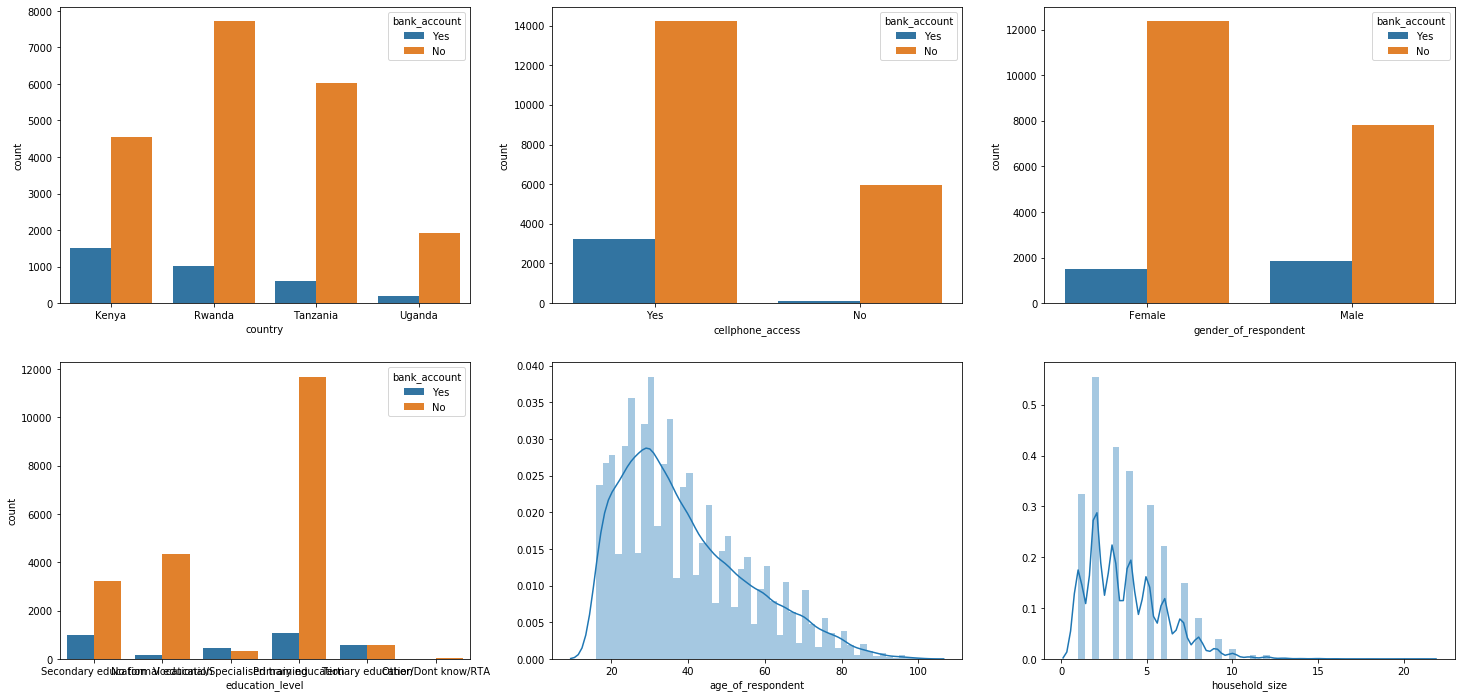

In [5]:
f,ax = plt.subplots(2,3,figsize=(25,12))
sns.countplot('country',hue='bank_account',data = df,ax=ax[0,0])
sns.countplot('cellphone_access',hue='bank_account',data = df,ax=ax[0,1])
sns.countplot('gender_of_respondent',hue='bank_account',data = df,ax=ax[0,2])
sns.countplot('education_level',hue='bank_account',data = df,ax=ax[1,0])
#sns.countplot('age_of_respondent',hue='bank_account',data = df,ax=ax[1,1])
sns.distplot(df['age_of_respondent'],ax=ax[1,1])
sns.distplot(df['household_size'],ax=ax[1,2])
#sns.countplot('household_size',hue='bank_account',data = df,ax=ax[1,2])

In [6]:
df,a,b = preprocess(df,True)

In [13]:
y= df.bank_account
x= df.drop(['bank_account'],axis=1)

# selecting features 

from sklearn.ensemble import ExtraTreesClassifier

TOP_FEATURES = 17

forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)
forest.fit(x, y)

importances = forest.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in forest.estimators_],
    axis=0
)
indices = np.argsort(importances)[::-1]
indices = indices[:TOP_FEATURES]
x = x.iloc[:,indices]

#splitting the data

from sklearn.model_selection import train_test_split
x_train, X_test, y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#scaling the data

from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
x_train = scaler.fit_transform(x_train)
X_test = scaler.transform(X_test)


#the dataset is unbalanced 

from imblearn.under_sampling import TomekLinks

tl = TomekLinks(ratio='majority')
x_train, y_train = tl.fit_sample(x_train, y_train)

In [16]:

gb_clf = GradientBoostingClassifier(n_estimators=307, learning_rate=0.207673, max_features=5, max_depth=3, random_state=42)
#GradientBoostingClassifier(n_estimators=800, learning_rate=0.04, max_features=2, max_depth=2, random_state=42) depth = 3
#GradientBoostingClassifier(n_estimators=200, learning_rate=0.2, max_features=5, max_depth=3, random_state=42)
#RandomForestClassifier(n_estimators=100) RandomForestClassifier(max_depth = 4,class_weight ={0:0.58,1:3.51})

gb_clf.fit(x_train, y_train) # 307 0.2 5 3 42

predictions = gb_clf.predict(X_test)


from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(Y_test,predictions),'\n   0    1')

print(classification_report(Y_test,predictions))

[[3927  136]
 [ 403  239]] 
   0    1
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4063
           1       0.64      0.37      0.47       642

    accuracy                           0.89      4705
   macro avg       0.77      0.67      0.70      4705
weighted avg       0.87      0.89      0.87      4705



In [18]:
x_test = pd.read_csv('./Test_V2.csv')

x_test,x_id,x_country = preprocess(x_test,False)

x_test  = x_test.iloc[:,indices]

scaler= StandardScaler()
x_test = scaler.fit_transform(x_test)


prediction = gb_clf.predict(x_test)

uniqe = np.array(x_id)
country = np.array(x_country)
l = []

for i in range(len(x_id)) :
    l.append(x_id[i]+' x '+x_country[i])
    
data = np.array(l)
pred= pd.DataFrame(prediction,columns = ['bank_account'])
data= pd.DataFrame(data,columns = ['uniqueid'])

data['bank_account'] = pred

print('there is :' + pred.mean() '% of people having bank account')

data.to_csv('./submission11.csv',index=False) #0.077434 76938 the best 77037

bank_account    0.078822
dtype: float64
